### Conv size calculator

https://madebyollin.github.io/convnet-calculator

https://theano-pymc.readthedocs.io/en/latest/tutorial/conv_arithmetic.html

https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html#torch.nn.Conv2d


### Imports

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix#,plot_confusion_matrix
from sklearn import metrics
import itertools

%matplotlib inline

### Functions

In [2]:
def classes_counter(dataset):
    K = len(set(dataset.targets.numpy()))
    return K

def dataloader_batch(train_dataset,test_dataset,batch_size=128):
    train_loader = torch.utils.data.DataLoader(dataset=train_dataset,batch_size=batch_size,shuffle=True)
    # to prevent unwanted correlation in train_data we shuffle train data
    test_loader  = torch.utils.data.DataLoader(dataset=test_dataset,batch_size=batch_size,shuffle=False)
    return train_loader,test_loader


def create_model_and_train(K,train_dataset,test_dataset,model_mode="CNN",batch_size=128,n_epochs=100):
    if model_mode=="CNN":
        model = CNN(K)
    elif model_mode=="Linear":
        model = nn.Sequential(
            nn.Linear(784,128),
            nn.ReLU(),
            nn.Linear(128,10),
            )

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print(device)
    model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters())
    
    train_loader,test_loader = dataloader_batch(train_dataset,test_dataset,batch_size=batch_size)
    
    train_losses = np.zeros(n_epochs)
    test_losses = np.zeros(n_epochs)
    
    for it in range(n_epochs):
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,784)

            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            
            loss.backward()
            optimizer.step()
            
            train_loss.append(loss.item())
            
        train_loss = np.mean(train_loss)
        
        test_loss = []
        for inputs, targets in test_loader:
            inputs,targets = inputs.to(device), targets.to(device)
            if model_mode=="Linear":
                inputs = inputs.view(-1,784)
            
            outputs = model(inputs)

            loss = criterion(outputs, targets)
                        
            test_loss.append(loss.item())
            
        test_loss = np.mean(test_loss)
        
        train_losses[it] = train_loss
        test_losses[it]  = test_loss
        
        dt = datetime.now() - t0
        print(f"Epoch {it+1}/{n_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Duration: {dt}")
        
    return model,train_losses, test_losses, device, train_loader, test_loader


def plot_test_and_train_metric(train, test, metric):
    plt.plot(train, label=f"train {metric}")
    plt.plot(test, label =f"test {metric}")
    plt.legend()
    plt.show
    

def acc_compouter(model,device,data_loader,model_mode="CNN"):
    n_correct=0.
    n_total=0.
    
    for inputs,targets in data_loader:
        inputs,targets = inputs.to(device), targets.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,784)

        outputs = model(inputs)
        
        _,predictions = torch.max(outputs,1)
        # 1 is the axis and  _ is the max value that is not needed here
        
        n_correct += (predictions == targets).sum().item()
        # .item() from torch to simple python data type
        n_total += targets.shape[0]
        
    train_acc = n_correct/n_total

    return train_acc

def predict_model(model,data_loader,dataset,device,model_mode="CNN"):
    x = dataset.data.numpy()
    y = dataset.targets.numpy()
    p = np.array([])
    for inputs,targets in data_loader:
        inputs = inputs.to(device)
        if model_mode=="Linear":
            inputs = inputs.view(-1,784)
        
        outputs = model(inputs)
        _,predictions = torch.max(outputs,1)
        p = np.concatenate((p,predictions.cpu().numpy()))
        
    return p,y,x

def plot_confusion_matrix(cm, classes, normalize=False, title="Confusion matrix", cmap=plt.cm.Blues):
    if normalize:
        cm=cm.astype("float") / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print("Confusion matrix, without normalization")
    print(cm)
    
    plt.imshow(cm, interpolation="nearest",cmap=cmap)
    plt.title(title)
    plt.colorbar()
    
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    
    fmt = ".2f" if normalize else "d"
    thresh = cm.max()/2.
    
    for i,j in itertools.product(range(cm.shape[0]),range(cm.shape[1])):
        plt.text(j,i,format(cm[i,j],fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.show()

### Load data

In [3]:
train_dataset_Fashion = torchvision.datasets.FashionMNIST(root=".",train=True,transform = transforms.ToTensor(),download=True)


train_dataset_MNIST = torchvision.datasets.MNIST(root=".",train=True,transform=transforms.ToTensor(),download=True)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./FashionMNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



In [4]:
train_dataset_Fashion.data.max()

tensor(255, dtype=torch.uint8)

In [5]:
train_dataset_Fashion.data.shape

torch.Size([60000, 28, 28])

In [6]:
train_dataset_Fashion.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [7]:
test_dataset_Fashion = torchvision.datasets.FashionMNIST(root=".",train=False ,transform = transforms.ToTensor(),download=True)

test_dataset_MNIST = torchvision.datasets.MNIST(root=".",train=False,transform=transforms.ToTensor(),download=True)

In [8]:
K_Fashion = classes_counter(train_dataset_Fashion)
K_MNIST   = classes_counter(train_dataset_MNIST)

print(K_Fashion)
print(K_MNIST)

10
10


### Create model

In [9]:
class CNN(nn.Module):
    def __init__(self,K):
        super(CNN,self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
            nn.ReLU(),            
        )
        
        self.dense_layers = nn.Sequential(
            nn.Dropout(0.2),
            nn.Linear(128*2*2, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(512,K)
        )
        
    def forward(self, X):
        out = self.conv_layers(X)
        out = out.view(out.size(0),-1)
        out = self.dense_layers(out)
        return out

    
    
# not available at this version -- on my system
# class CNN_flatten(nn.Module):
#     def __init__(self,K):
#         super(CNN_flatten,self).__init__()
        
#         nn.Sequential(
#             nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2),
#             nn.ReLU(),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2),
#             nn.ReLU(), 
            
#             nn.Flatten(),
            
#             nn.Dropout(0.2),
#             nn.Linear(128*2*2, 512),
#             nn.ReLU(),
#             nn.Dropout(0.2),
#             nn.Linear(512,K)
#         )

#### 1. MNIST Linear

In [11]:
model_MNIST_Linear, train_losses_MNIST_Linear, test_losses_MNIST_Linear, device ,train_loader_MNIST, test_loader_MNIST = create_model_and_train(K_MNIST,train_dataset_MNIST,test_dataset_MNIST,model_mode="Linear",batch_size=128,n_epochs=100)

cuda:0
Epoch 1/100, Train Loss: 0.4167, Test Loss: 0.2248, Duration: 0:00:08.778720
Epoch 2/100, Train Loss: 0.1936, Test Loss: 0.1542, Duration: 0:00:08.836563
Epoch 3/100, Train Loss: 0.1400, Test Loss: 0.1268, Duration: 0:00:08.823925
Epoch 4/100, Train Loss: 0.1101, Test Loss: 0.1101, Duration: 0:00:08.730260
Epoch 5/100, Train Loss: 0.0896, Test Loss: 0.0952, Duration: 0:00:08.793942
Epoch 6/100, Train Loss: 0.0748, Test Loss: 0.0930, Duration: 0:00:08.925182
Epoch 7/100, Train Loss: 0.0631, Test Loss: 0.0878, Duration: 0:00:08.867312
Epoch 8/100, Train Loss: 0.0533, Test Loss: 0.0794, Duration: 0:00:08.992372
Epoch 9/100, Train Loss: 0.0459, Test Loss: 0.0806, Duration: 0:00:08.901796
Epoch 10/100, Train Loss: 0.0391, Test Loss: 0.0756, Duration: 0:00:08.907166
Epoch 11/100, Train Loss: 0.0328, Test Loss: 0.0732, Duration: 0:00:08.898066
Epoch 12/100, Train Loss: 0.0282, Test Loss: 0.0714, Duration: 0:00:08.928043
Epoch 13/100, Train Loss: 0.0240, Test Loss: 0.0724, Duration: 0:0

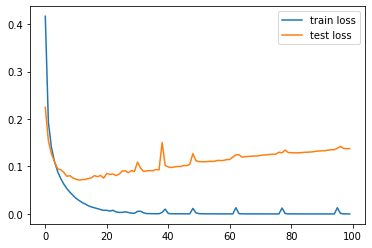

In [12]:
plot_test_and_train_metric(train_losses_MNIST_Linear, test_losses_MNIST_Linear,"loss")

In [13]:
train_acc_MNIST_Linear = acc_compouter(model_MNIST_Linear,device,train_loader_MNIST,model_mode="Linear")
print(f"train acc: {train_acc_MNIST_Linear}")

test_acc_MNIST_Linear = acc_compouter(model_MNIST_Linear,device,test_loader_MNIST,model_mode="Linear")
print(f"test acc: {test_acc_MNIST_Linear}")

train acc: 1.0
test acc: 0.9791


Confusion matrix, without normalization
[[ 969    1    3    0    1    0    3    0    2    1]
 [   0 1125    4    0    0    0    1    1    4    0]
 [   4    2 1010    1    0    0    2    4    8    1]
 [   0    0    5  987    0    5    0    3    3    7]
 [   0    0    1    1  963    1    6    1    2    7]
 [   3    1    0   10    2  865    3    2    5    1]
 [   4    2    3    1    4    4  938    0    2    0]
 [   0    7    8    3    0    0    0 1002    3    5]
 [   5    0    4    4    3    2    0    5  947    4]
 [   1    2    1    3    8    3    0    3    3  985]]


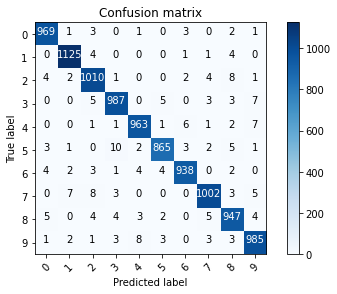

In [14]:
p_test_MNIST_Linear,y_test_MNIST,x_test_MNIST = predict_model(model_MNIST_Linear,test_loader_MNIST,test_dataset_MNIST,device,model_mode="Linear")

cm_MNIST_Linear = confusion_matrix(y_test_MNIST,p_test_MNIST_Linear)
plot_confusion_matrix(cm_MNIST_Linear, list(range(K_MNIST)))

#### 2. MNIST CNN

In [15]:
model_MNIST_CNN, train_losses_MNIST_CNN, test_losses_MNIST_CNN, _ ,_, _ = create_model_and_train(K_MNIST,train_dataset_MNIST,test_dataset_MNIST,model_mode="CNN",batch_size=128,n_epochs=100)

cuda:0
Epoch 1/100, Train Loss: 0.3125, Test Loss: 0.1199, Duration: 0:00:12.156429
Epoch 2/100, Train Loss: 0.0978, Test Loss: 0.0707, Duration: 0:00:11.973619
Epoch 3/100, Train Loss: 0.0705, Test Loss: 0.0600, Duration: 0:00:12.028363
Epoch 4/100, Train Loss: 0.0549, Test Loss: 0.0561, Duration: 0:00:12.077219
Epoch 5/100, Train Loss: 0.0440, Test Loss: 0.0553, Duration: 0:00:12.002732
Epoch 6/100, Train Loss: 0.0381, Test Loss: 0.0569, Duration: 0:00:12.003407
Epoch 7/100, Train Loss: 0.0327, Test Loss: 0.0481, Duration: 0:00:11.996646
Epoch 8/100, Train Loss: 0.0286, Test Loss: 0.0452, Duration: 0:00:12.037870
Epoch 9/100, Train Loss: 0.0231, Test Loss: 0.0408, Duration: 0:00:12.031926
Epoch 10/100, Train Loss: 0.0225, Test Loss: 0.0477, Duration: 0:00:12.068741
Epoch 11/100, Train Loss: 0.0186, Test Loss: 0.0503, Duration: 0:00:11.971379
Epoch 12/100, Train Loss: 0.0186, Test Loss: 0.0531, Duration: 0:00:12.017499
Epoch 13/100, Train Loss: 0.0169, Test Loss: 0.0447, Duration: 0:0

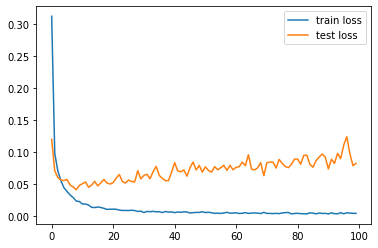

In [16]:
plot_test_and_train_metric(train_losses_MNIST_CNN, test_losses_MNIST_CNN,"loss")

In [17]:
train_acc_MNIST_CNN = acc_compouter(model_MNIST_CNN,device,train_loader_MNIST,model_mode="CNN")
print(f"train acc: {train_acc_MNIST_Linear}")

test_acc_MNIST_CNN = acc_compouter(model_MNIST_CNN,device,test_loader_MNIST,model_mode="CNN")
print(f"test acc: {test_acc_MNIST_CNN}")

train acc: 1.0
test acc: 0.9884


Confusion matrix, without normalization
[[ 969    1    3    0    1    0    3    0    2    1]
 [   0 1125    4    0    0    0    1    1    4    0]
 [   4    2 1010    1    0    0    2    4    8    1]
 [   0    0    5  987    0    5    0    3    3    7]
 [   0    0    1    1  963    1    6    1    2    7]
 [   3    1    0   10    2  865    3    2    5    1]
 [   4    2    3    1    4    4  938    0    2    0]
 [   0    7    8    3    0    0    0 1002    3    5]
 [   5    0    4    4    3    2    0    5  947    4]
 [   1    2    1    3    8    3    0    3    3  985]]


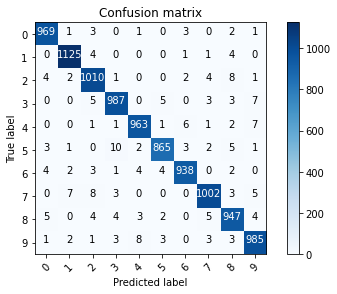

In [18]:
p_test_MNIST_CNN,y_test_MNIST,x_test_MNIST = predict_model(model_MNIST_CNN,test_loader_MNIST,test_dataset_MNIST,device,model_mode="CNN")

cm_MNIST_CNN = confusion_matrix(y_test_MNIST,p_test_MNIST_Linear)
plot_confusion_matrix(cm_MNIST_CNN, list(range(K_MNIST)))

#### 3. Fashion Linear

In [19]:
model_Fashion_Linear, train_losses_Fashion_Linear, test_losses_Fashion_Linear, _ ,train_loader_Fashion, test_loader_Fashion = create_model_and_train(K_Fashion,train_dataset_Fashion,test_dataset_Fashion,model_mode="Linear",batch_size=128,n_epochs=100)

cuda:0
Epoch 1/100, Train Loss: 0.6020, Test Loss: 0.4695, Duration: 0:00:09.005411
Epoch 2/100, Train Loss: 0.4255, Test Loss: 0.4386, Duration: 0:00:08.903057
Epoch 3/100, Train Loss: 0.3859, Test Loss: 0.4124, Duration: 0:00:08.966050
Epoch 4/100, Train Loss: 0.3558, Test Loss: 0.3833, Duration: 0:00:09.023849
Epoch 5/100, Train Loss: 0.3356, Test Loss: 0.3683, Duration: 0:00:08.941256
Epoch 6/100, Train Loss: 0.3177, Test Loss: 0.3724, Duration: 0:00:08.970579
Epoch 7/100, Train Loss: 0.3062, Test Loss: 0.3579, Duration: 0:00:08.980373
Epoch 8/100, Train Loss: 0.2934, Test Loss: 0.3528, Duration: 0:00:08.954068
Epoch 9/100, Train Loss: 0.2836, Test Loss: 0.3611, Duration: 0:00:08.980846
Epoch 10/100, Train Loss: 0.2735, Test Loss: 0.3344, Duration: 0:00:09.005139
Epoch 11/100, Train Loss: 0.2667, Test Loss: 0.3359, Duration: 0:00:08.918747
Epoch 12/100, Train Loss: 0.2593, Test Loss: 0.3484, Duration: 0:00:08.910286
Epoch 13/100, Train Loss: 0.2530, Test Loss: 0.3295, Duration: 0:0

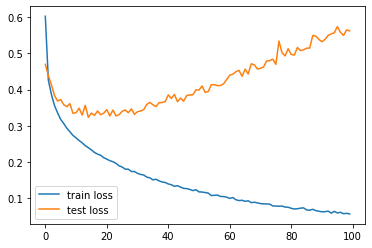

In [20]:
plot_test_and_train_metric(train_losses_Fashion_Linear, test_losses_Fashion_Linear,"loss")

In [21]:
train_acc_Fashion_Linear = acc_compouter(model_Fashion_Linear,device,train_loader_Fashion,model_mode="Linear")
print(f"train acc: {train_acc_Fashion_Linear}")

test_acc_Fashion_Linear = acc_compouter(model_Fashion_Linear,device,test_loader_Fashion,model_mode="Linear")
print(f"test acc: {test_acc_Fashion_Linear}")

train acc: 0.9827166666666667
test acc: 0.8864


Confusion matrix, without normalization
[[835   3  18  19   7   1 109   2   6   0]
 [  1 982   1   6   4   0   4   0   2   0]
 [ 19   1 752  10 135   2  80   0   1   0]
 [ 29   9  13 866  41   1  37   0   3   1]
 [  0   0  42  26 873   0  58   0   1   0]
 [  2   0   0   1   0 954   0  29   2  12]
 [113   2  75  18  72   1 710   0   8   1]
 [  0   0   0   0   0  11   0 958   0  31]
 [  8   0   5   4   1   3   5   4 970   0]
 [  0   0   0   0   0  10   1  25   0 964]]


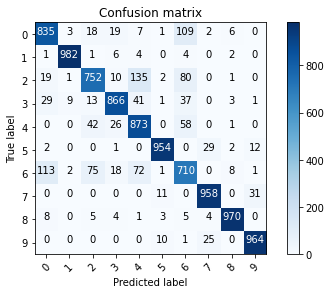

In [22]:
p_test_Fashion_Linear,y_test_Fashion,x_test_Fashion = predict_model(model_Fashion_Linear,test_loader_Fashion,test_dataset_Fashion,device,model_mode="Linear")

cm_Fashion_Linear = confusion_matrix(y_test_Fashion,p_test_Fashion_Linear)
plot_confusion_matrix(cm_Fashion_Linear, list(range(K_Fashion)))

#### 4. Fashion CNN

In [23]:
model_Fashion_CNN, train_losses_Fashion_CNN, test_losses_Fashion_CNN, _ ,train_loader_Fashion, test_loader_Fashion = create_model_and_train(K_Fashion,train_dataset_Fashion,test_dataset_Fashion,model_mode="CNN",batch_size=128,n_epochs=100)

cuda:0
Epoch 1/100, Train Loss: 0.6497, Test Loss: 0.5049, Duration: 0:00:12.027514
Epoch 2/100, Train Loss: 0.4335, Test Loss: 0.4187, Duration: 0:00:12.027050
Epoch 3/100, Train Loss: 0.3775, Test Loss: 0.3875, Duration: 0:00:11.953763
Epoch 4/100, Train Loss: 0.3417, Test Loss: 0.3581, Duration: 0:00:12.116054
Epoch 5/100, Train Loss: 0.3176, Test Loss: 0.3578, Duration: 0:00:12.024386
Epoch 6/100, Train Loss: 0.2929, Test Loss: 0.3447, Duration: 0:00:12.092977
Epoch 7/100, Train Loss: 0.2739, Test Loss: 0.3209, Duration: 0:00:11.987522
Epoch 8/100, Train Loss: 0.2584, Test Loss: 0.3239, Duration: 0:00:12.069683
Epoch 9/100, Train Loss: 0.2442, Test Loss: 0.3229, Duration: 0:00:11.986163
Epoch 10/100, Train Loss: 0.2292, Test Loss: 0.3089, Duration: 0:00:12.031731
Epoch 11/100, Train Loss: 0.2171, Test Loss: 0.3220, Duration: 0:00:11.936875
Epoch 12/100, Train Loss: 0.2060, Test Loss: 0.3075, Duration: 0:00:12.004446
Epoch 13/100, Train Loss: 0.1951, Test Loss: 0.3146, Duration: 0:0

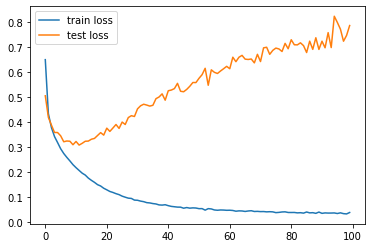

In [24]:
plot_test_and_train_metric(train_losses_Fashion_CNN, test_losses_Fashion_CNN,"loss")

In [25]:
train_acc_Fashion_CNN = acc_compouter(model_Fashion_CNN,device,train_loader_Fashion,model_mode="CNN")
print(f"train acc: {train_acc_Fashion_CNN}")

test_acc_Fashion_CNN = acc_compouter(model_Fashion_CNN,device,test_loader_Fashion,model_mode="CNN")
print(f"test acc: {test_acc_Fashion_CNN}")

train acc: 0.98945
test acc: 0.8956


Confusion matrix, without normalization
[[835   3  18  19   7   1 109   2   6   0]
 [  1 982   1   6   4   0   4   0   2   0]
 [ 19   1 752  10 135   2  80   0   1   0]
 [ 29   9  13 866  41   1  37   0   3   1]
 [  0   0  42  26 873   0  58   0   1   0]
 [  2   0   0   1   0 954   0  29   2  12]
 [113   2  75  18  72   1 710   0   8   1]
 [  0   0   0   0   0  11   0 958   0  31]
 [  8   0   5   4   1   3   5   4 970   0]
 [  0   0   0   0   0  10   1  25   0 964]]


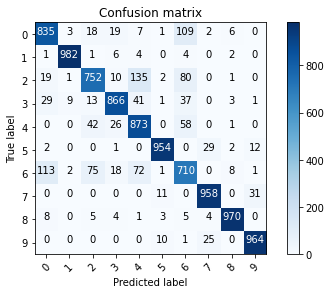

In [26]:
p_test_Fashion_CNN,y_test_Fashion,x_test_Fashion = predict_model(model_Fashion_CNN,test_loader_Fashion,test_dataset_Fashion,device,model_mode="CNN")

cm_Fashion_CNN = confusion_matrix(y_test_Fashion,p_test_Fashion_Linear)
plot_confusion_matrix(cm_Fashion_CNN, list(range(K_Fashion)))

In [1]:
fashion_labels = '''Tshirt/top
Trouser
Pullover
Dress
Coat
Sandal
Shirt
Sneaker
Bag
Ankle boot
'''.split("\n")

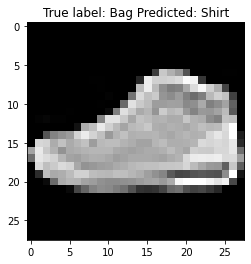

In [28]:
p_test_Fashion_CNN = p_test_Fashion_CNN.astype(np.uint8)
misclassified_idx = np.where(p_test_Fashion_CNN!=y_test_Fashion)[0]
i = np.random.choice(misclassified_idx)
plt.imshow(x_test_Fashion[i],cmap="gray")
plt.title("True label: %s Predicted: %s" % (fashion_labels[y_test_Fashion[i]], fashion_labels[int(p_test_Fashion_CNN[i])]));